In [2]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np 
import optax as ox
import xarray as xr

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Read

### Obs

In [10]:
def prepro(ds):
    model_real = ds.encoding['source'].split('_')[-1][:-3]
    ds = ds.assign_coords(realisation=model_real)
    return ds

/home/amosm1/bayesian_ensembling/ensembles/data.py:95: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


<AxesSubplot:title={'center':'Observations'}>

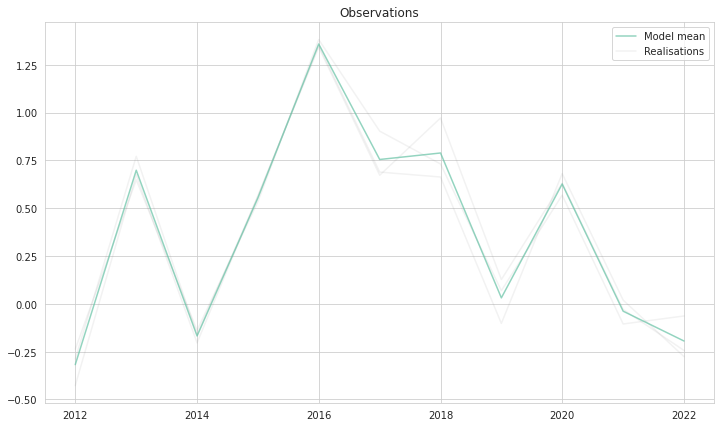

In [29]:
obs_da = xr.open_mfdataset(glob('./../experiments/data/obs/Had*.nc'), combine='nested', concat_dim='realization').tas.load()[:, -120:, 15:18, 15:19]
obs_da = obs_da.rename(realization='realisation')
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()

### Anomaly model data

In [31]:
cnrm_da = xr.open_mfdataset(glob('./../experiments/data/gridded/CNRM*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]
can_da = xr.open_mfdataset(glob('./../experiments/data/gridded/CCC*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]
ecearth_da = xr.open_mfdataset(glob('./../experiments/data/gridded/EC*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]

can_da['time'] = cnrm_da['time']
ecearth_da['time'] = cnrm_da['time']

cnrm_model = es.ProcessModel(cnrm_da, 'CNRM')
cnrm_anomaly = cnrm_model.calculate_anomaly(resample_freq='Y')

can_model = es.ProcessModel(can_da, 'CAN')
can_anomaly = can_model.calculate_anomaly(resample_freq='Y')

ec_model = es.ProcessModel(ecearth_da, 'EC-EARTH')
ec_anomaly = ec_model.calculate_anomaly(resample_freq='Y')


/home/amosm1/bayesian_ensembling/ensembles/data.py:218: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/amosm1/bayesian_ensembling/ensembles/data.py:218: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/amosm1/bayesian_ensembling/ensembles/data.py:218: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


<AxesSubplot:>

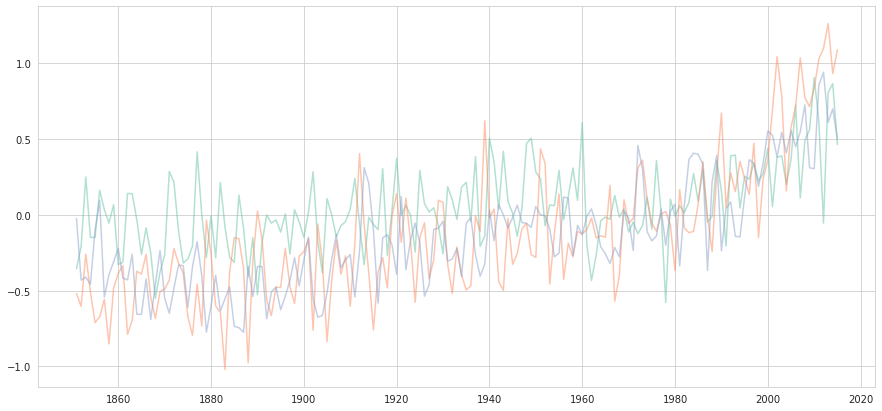

In [33]:
hist_anom_models = es.ModelCollection([cnrm_anomaly, can_anomaly, ec_anomaly])
hist_anom_models.plot_all()

### Construct posteriors for historic data

In [9]:
hist_anom_models.fit(model=es.GPDTW(), compile_objective=True)

NotImplementedError: Not implemented for more than temporal dimensions

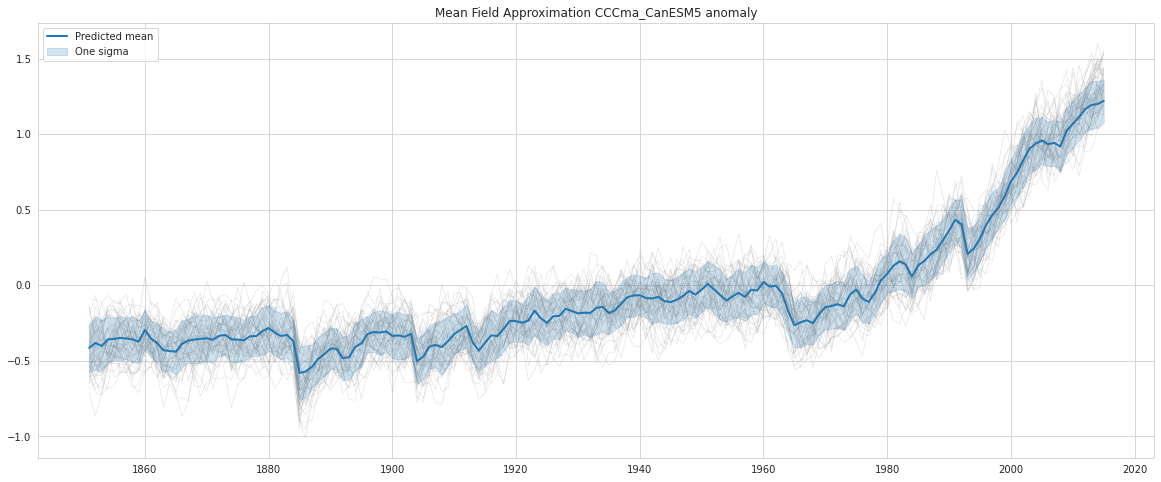

In [7]:
model_idx = 0
mu = hist_anom_models[model_idx].distribution.mean()
stddev = hist_anom_models[model_idx].distribution.stddev()
realisations = hist_anom_models[model_idx].model_data.values

fig,ax = plt.subplots(figsize=(20,8))
ax.plot(hist_anom_models[model_idx].time, mu, color='tab:blue', label='Predicted mean', linewidth=2, zorder=2)
ax.fill_between(hist_anom_models[model_idx].time.values, mu - stddev, mu + stddev, color='tab:blue', alpha=0.2, label='One sigma', zorder=2)
ax.plot(hist_anom_models[model_idx].time, realisations.T, color='tab:gray', alpha=0.2, zorder=1, linewidth=0.7)
ax.legend(loc='best')
ax.set_title(f'Mean Field Approximation {hist_anom_models[model_idx].model_name}')
plt.show()

In [8]:
weight_function = es.LogLikelihoodWeight()
weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:01<00:00, 141.29it/s]


In [9]:
ensemble = es.Barycentre()
pdfs = ensemble(hist_anom_models, weights)

100%|██████████| 165/165 [00:03<00:00, 51.38it/s]


### Hindcast ensemble

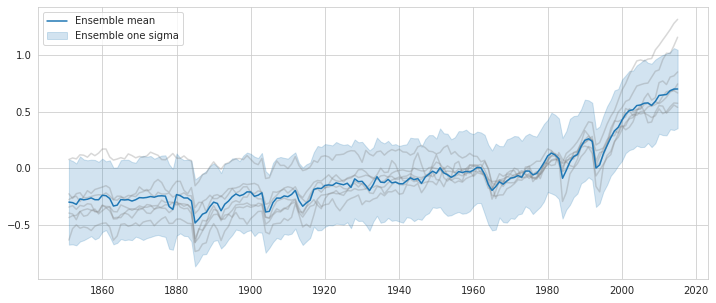

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=hist_anom_models.time.values)
ax.legend(loc='best')

### Forecast Ensemble

In [11]:
ssp_anom_models.fit(model=es.GPDTW(), compile_objective=True, n_optim_nits=1000)

 42%|████▏     | 418/1000 [00:25<00:35, 16.18it/s, loss=62.09] 

### Calculate weights using different schemes

In [5]:
uniform_weights = es.UniformWeight()(hist_anom_models)
mse_weights = es.InverseSquareWeight()(hist_anom_models, observations)

weight_function = es.LogLikelihoodWeight()
ll_weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:07<00:00, 27.51it/s]


### Construct different ensemble outputs

In [6]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=mse_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models)
weighted_barycentre = es.Barycentre()(hist_anom_models, weights=ll_weights)

100%|██████████| 1980/1980 [00:18<00:00, 107.27it/s]
